<img src="images/escudo_utfsm.gif" style="float:right;height:100px">
<img src="images/IsotipoDIisocolor.png" style="float:left;height:100px">
<center>

    <i><h2 style="font-family:serif;font-size:300%; text-align:center;color:#283A5B"> Tarea 0</h2></i>
    <h1 style="font-family:serif;font-size:200%; text-align:center;color:#4d4d4d"> <i> Redes Neuronales Artificiales - San Joaquín </i></h1>
    <h3 style = 'font-family:serif;font-size:120%'><i> Ignacio Loayza C. 201273604-8</i></h3>
    <h3 style = 'font-family:serif;font-size:120%'><i> Camilo Pérez P. 201273533-5</i></h3>

</center>

<p>
<center>_Abril 2018_ </center>
</p>

In [3]:
# encoding: utf-8
%matplotlib inline

# semilla
seed = hash("Ñanculef es mi pastor, nada me ha de faltar")%2^32

# Imports

#Neural Networks
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import Callback

import tensorflow as tf

# Numerico
import numpy as np
import pandas as pd

#Machine Learning
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Timer
from timeit import default_timer as timer

#Metricas

#Graficos
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_style("darkgrid")

# Warnings
import warnings
warnings.filterwarnings('ignore')

#Shallow copy
import copy

#preprocesamiento


#HTML incrustation
from IPython.display import display, HTML

display(HTML("""
<style>
p {
    color: black;
    font-family: Serif;
    font-size: 1.23em;
}
.output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
    }

</style>

"""))


Using TensorFlow backend.


<i><h2 style="font-family:serif;font-size:260%; text-align:center;color:#004d80"> Back-propagation from Scratch</h2></i>

<i><h3 style="font-family:serif;font-size:200%; text-align:left;color:#4d4d4d"> I) Entrenando una red FF mediante Back-propagation</h3></i>

Comenzaremos entrenando una red del tipo *Feed Forward* con arquitectura de dos capas ocultas, distribuidas de la forma  32:16 neuronas en las capas y *K* neuronas de salida.

In [125]:
## Clases necesarias

class Network:
    def __init__(self, n_inputs, neurons_each_layer, n_outputs):
        self.n_inputs = n_inputs
        self.neurons_each_layer = neurons_each_layer
        self.n_outputs = n_outputs
        
        # Inicializacion de las capas
        layers_array = []
        index = 0
        n_neurons_prev_layer = 0 # para la capa de input

        #input layer
        layers_array.append(Layer(n_inputs, 0, index))
        n_neurons_prev_layer = n_inputs

        #Hidden layers
        for layer_conf in neurons_each_layer:
            index+=1
            layers_array.append(Layer(layer_conf, n_neurons_prev_layer,index))
            n_neurons_prev_layer = layer_conf
        ## Aqui agregar la posibilidad de indicar funciones de transferencia para las capas
        
        #Output layer
        index+=1
        layers_array.append(Layer(n_outputs, n_neurons_prev_layer, index))
        self.hidden_layers = layers_array
            
    ############# Getters & Setters ###########################    
    def get_weights_matrix(self, layer_index):
        return self.hidden_layers[layer_index].get_weights_matrix()
    
    def get_n_inputs(self):
        return self.n_inputs
    def get_neurons_each_layer(self):
        return self.neurons_each_layer
    def get_n_outputs(self):
        return self.n_outputs

    def get_network_parameters(self):
        network_params = {'n_inputs':self.n_inputs,
                        'neurons_each_layer':self.neurons_each_layer,
                        'n_outputs':self.n_outputs,
                         'hidden_layers':self.hidden_layers}
        return network_params
    
    #########################################################
    
    def forward_propagate(self, data_row):
        previous_activations = np.ones((self.n_inputs,1))
        
        for layer in self.hidden_layers:
            if(layer.get_index() == 0):#Si es la primera capa le tenemos que pasar la data_column como las activaciones
                layer.compute_layer_activations(np.transpose(data_row))
                previous_activations = layer.get_activations_column()
            else:
                layer.compute_layer_activations(previous_activations)
                previous_activations = layer.get_activations_column()
                
    def backward_pass(self, expected_predictions):
        # Primero calculamos el error para cada neurona de la capa de output
        # Para calcular la señal de error de la capa de output lo hacemos con respecto a la
        # fila de datos

        previous_errors = np.transpose(self.calculate_output_error(expected_predictions))
        previous_weights = np.ones((self.get_n_outputs(), self.get_n_outputs()))
        
        for layer in self.hidden_layers[:0:-1]:
                #Si es la capa de output, usamos las predicciones esperadas de salida
                # La señal de error de la capa de output es la funcion de error evaluada en las predicciones
                # multiplicada por los pesos que llegan a la capa de output
                
            # calculo de la señal de error
            layer.set_error_signals(np.dot(np.transpose(previous_weights),previous_errors))
            
            previous_errors = layer.get_error_signals()
            previous_weights = layer.get_weights_matrix()
            
            #update de los pesos
            layer.update_weights()
        return
        
        
        #Usemos el error cuadratico medio (MSE)
    def calculate_output_error(self, expected):
        return self.calculate_loss(expected)*self.hidden_layers[-1].transfer_derivative(self.hidden_layers[-1].get_activations_column())
    
    def calculate_loss(self, expected): 
        predicted = self.hidden_layers[-1].get_activations_column()
        return np.power(expected - predicted,2)/2
    
    def gradient_loss(self, expected):
        predicted = self.hidden_layers[-1].get_activations_column()
        return predicted - expected
                
        

    def train(self, df_train, df_validate):
        #Chequear si el numero de atributos concuerda con el numero de inputs especificados
        if(len(df_train.columns) != self.n_inputs):
            print('El número de columnas del dataset no coincide con el número de inputs especificado para esta red')
            print("Número de columnas del dataset: %d" %len(df_train.columns))
            print("Número de inputs aceptados por la red: %d" %self.n_inputs)
            return
        
        for index, train_row in df_train.iterrows():
            # extraer una fila y forward propagate
            self.forward_propagate(train_row)
            # backprop = backward pass + update weights
            self.backward_pass(df_validate.iloc[[index]])
        return

    def predict(self, X_train):
        self.forward_propagate(X_train)
        predicted = self.hidden_layers[-1].transfer(self.hidden_layers[-1].get_activations_column())
        return predicted
            
        
        
        
        
class Layer:
    def __init__(self, neurons_in_layer, neurons_previous_layer, index, **kargs):
        self.layer_index = index
        self.neurons_in_layer = neurons_in_layer
        self.activations_column = np.zeros((self.neurons_in_layer, 1))
        self.error_signals = np.zeros((self.neurons_in_layer,1))
        
        #Funciones de transferencia disponibles para la capa
        if('transfer_func' in kargs):
            if(kargs['transfer_func'] == 'sigmoid'):
                self.transfer = self.sigmoid
                self.transfer_derivative = self.sigmoid_derivative
            elif(kargs['transfer_func'] == 'softmax'):
                self.transfer = self.softmax
                self.transfer_derivative = self.softmax_derivative
            elif(kargs['transfer_func'] == 'lineal' or index == 0): #Si es la capa de inputs le damos transferencia lineal
                self.transfer = self.linear
                self.transfer_derivative = self.linear_derivative
        elif(index == 0):# La primera capa es la capa de input, con transferencia lineal
            self.transfer = self.linear
            self.transfer_derivative = self.linear_derivative
        else:# Si no se especifica una funcion de transferencia usaremos por defecto la sigmoidal
            self.transfer = self.sigmoid
            self.transfer_derivative = self.sigmoid_derivative
            
        if('learning_rate' in kargs):
            self.set_learning_rate(kargs['learning_rate'])
        else:# Si no se especifica learning_rate el defecto es 0.01
            self.set_learning_rate(0.1)
            
        #Si es la primera capa no tiene matriz de pesos
        if(self.layer_index == 0):
            self.weights_matrix = np.identity(self.neurons_in_layer)
            #Con esto logramos una matriz identidad que al ser multiplicada por el vector de inputs
            #nos da el mismo vector de inputs
        else:
            self.weights_matrix = np.random.rand(self.neurons_in_layer, neurons_previous_layer)
    
    def compute_layer_activations(self, activations_prev_layer):
        
        #Primero calculamos el input_sum, a la capa de input hay que simplemente pasarle la primera fila
        #de los datos como 'activations_prev_layer' cuando se entrene la red
        self.input_sum = np.dot(self.get_weights_matrix(), activations_prev_layer)
        
        #Ahora que calculamos el input sum, hay que pasar el resultado por la función de transferencia para ver
        #que es lo que las neuronas estan escupiendo

        self.activations_column = [self.transfer(activ_weights_sum) for activ_weights_sum in self.input_sum]
        #listo :V

    def update_weights(self):
        n_weights = np.subtract(self.get_weights_matrix(),np.dot(np.transpose(self.get_learning_rate()), self.get_error_signals()))
        self.set_weights_matrix(n_weights)
        
    ###### Funciones de activacion #########
    
    # Sigmoid
    def sigmoid(self, activation):
        TOL = 1e-12 #La sigmoidal se agila en los extremos asi que hay que ponerle un limite de tolerancia

        try:
            if(activation > 0):
                activ = np.maximum(TOL, activation)
            elif(activation < 0):
                activ = np.maximum(-100,activation)
        except TypeError:
            activation = activation[0]
            if(activation > 0):
                activ = np.maximum(TOL, activation)
            elif(activation < 0):
                activ = np.maximum(-100,activation)
        return 1 / (1 + np.exp(-activ))
    
    def sigmoid_derivative(self, input_sum):
        return self.sigmoid(input_sum)*(1.0 - self.sigmoid(input_sum))
    
    # SoftMax
    def softmax(self, activation):
        return exp(activation)/np.sum(map(exp, self.activations_column))
    def softmax_derivative(self, input_sum):
        return self.softmax(input_sum)(1.0 - self.softmax(input_sum))
        
    # Linear
    def linear(self, activation):
        return activation
    def linear_derivative(self, input_sum):
        return 1.0
    
    ########################################
    def get_parameters(self):
        layer_params = {'neurons_in_layer':self.neurons_in_layer, 'weights_matrix':self.weights_matrix, 
                        'index':self.layer_index, 'input_sum':self.input_sum, 
                        'activations_column':self.activations_column}
        return layer_params
    
    def get_weights_matrix(self):
        return self.weights_matrix
    def set_weights_matrix(self, new_weights):
        self.weights_matrix = new_weights
    
    def get_index(self):
        return self.layer_index
    
    def get_input_sum(self):
        return self.input_sum
    
    def get_activations_column(self):
        return self.activations_column
    def get_error_signals(self):
        return self.error_signals
    def set_error_signals(self, signals_column):
        self.error_signals = signals_column
    def set_learning_rate(self,learning_rate):
        self.learning_rate = learning_rate
    def get_learning_rate(self):
        return self.learning_rate
        
        


In [50]:
X_train,y_train = load_iris(return_X_y=True)
a = pd.DataFrame(X_train)
b = pd.DataFrame(y_train)

In [17]:
mynet = Network(4,(3,2), 1)
mynet.get_network_parameters()

{'hidden_layers': [<__main__.Layer at 0x12b396a90>,
 'n_inputs': 4,
 'n_outputs': 1,
 'neurons_each_layer': (3, 2)}

In [18]:
mynet.get_weights_matrix(1)

array([[ 0.9842867 ,  0.37803643,  0.10186341,  0.15097144],
       [ 0.76185856,  0.81476954,  0.82926856,  0.8590456 ],
       [ 0.94103374,  0.28061201,  0.9695843 ,  0.90559549]])

In [8]:
mynet.train(a[:1:], b[:1:])

5.13897071804
8.80331810489
2.74515545052
1.06177313234
1.16735848931
1.01849749518
0    0
Name: 0, dtype: int64
[0.73467982643419338]
[0.73467982643419338]


In [9]:
mynet.get_weights_matrix(1)

array([[[[ 0.26841866,  0.94546434,  0.27904739,  0.33751301],
         [ 0.93868183,  0.98551912,  0.27118351,  0.92162782],
         [ 0.21739391,  0.2317692 ,  0.50647655,  0.56722894]],

        [[ 0.26841473,  0.94546041,  0.27904346,  0.33750908],
         [ 0.9386779 ,  0.98551519,  0.27117958,  0.92162389],
         [ 0.21738998,  0.23176527,  0.50647262,  0.56722501]],

        [[ 0.26832819,  0.94537388,  0.27895692,  0.33742255],
         [ 0.93859136,  0.98542865,  0.27109304,  0.92153736],
         [ 0.21730344,  0.23167873,  0.50638608,  0.56713847]]]])

In [158]:
X_train, y_train = load_iris(return_X_y = True)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
y_onehot = to_categorical(y_train)


mynet = Network(4,(32,16), 3)
mynet.train(pd.DataFrame(X_train), pd.DataFrame(y_onehot))

Layer index: 0 

Activaciones de capa anterior:
0   -0.900681
1    1.032057
2   -1.341272
3   -1.312977
Name: 0, dtype: float64
Matriz de pesos:
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
Resultado del producto punto (input sum):
[-0.90068117  1.03205722 -1.3412724  -1.31297673]
Layer index: 1 

Activaciones de capa anterior:
[-0.90068117029780992, 1.0320572244889554, -1.3412724047598341, -1.3129767272601454]
Matriz de pesos:
[[ 0.03979589  0.74726191  0.7893957   0.24622795]
 [ 0.36542576  0.72858775  0.28915312  0.97043101]
 [ 0.94594418  0.02747818  0.60478528  0.33435709]
 [ 0.70229616  0.50525425  0.12480903  0.32955692]
 [ 0.21332201  0.38663513  0.63286897  0.36289194]
 [ 0.98171003  0.13212893  0.88349438  0.35641135]
 [ 0.27686635  0.50767406  0.06847206  0.37864312]
 [ 0.09525446  0.30570819  0.86840557  0.74204298]
 [ 0.57169894  0.50134295  0.24721849  0.29704178]
 [ 0.62859062  0.25283742  0.06084997  0.27010452]
 [ 0.78674155  0.55310922 

Layer index: 3 

Activaciones de capa anterior:
[0.99908544277667932, 0.99745735540785041, 0.99904718918018531, 0.99852259523333919, 0.99662660682033866, 0.99797458362652369, 0.99858371798454282, 0.99408933540283517, 0.99763832418949205, 0.998237744042349, 0.99704541811099989, 0.99675335043059377, 0.99496728609681429, 0.99674303971140665, 0.99842906347936922, 0.99913391047986821]
Matriz de pesos:
[[ 0.285789    0.12441242  0.01345484  0.07748907  0.52453565  0.95563532
   0.29475214  0.34479468  0.03604991  0.20228699  0.51063868  0.53126456
   0.79446467  0.62381805  0.50253848  0.31954024]
 [ 0.69870188  0.23130514  0.30878801  0.93711428  0.26819726  0.53459418
   0.95045542  0.56786841  0.31830702 -0.01086225  0.41014602  0.82728551
   0.68679242  0.25819312  0.3351929   0.79582931]
 [ 0.18934548  0.48739014  0.39805439 -0.01514325  0.85921679  0.67091154
   0.1882821   0.45428713  0.33679642  0.23669081  0.04706162  0.62338766
   0.82891216  0.90481273  0.36803674  0.20998018]]
Re

Layer index: 2 

Activaciones de capa anterior:
[0.67989804331181247, 0.59895360562052702, 0.28895101055395617, 0.71298682611463848, 0.54533862259550292, 0.26105959232569037, 0.67977358066030613, 0.34930630115308081, 0.67722267516735279, 0.57981671840582316, 0.35835773590941067, 0.56282345362247965, 0.64629021242040752, 0.71027018260628061, 0.48519034348698736, 0.64492284058244209, 0.36497393325646094, 0.6818133768345338, 0.70882328610000667, 0.79608235840589325, 0.3935592195721393, 0.55154347202838028, 0.79404078943530576, 0.56075443803857228, 0.58172933050933484, 0.41915421389595003, 0.4128691104972303, 0.36382117952600862, 0.62471265276480348, 0.43521822448588565, 0.64304443402241818, 0.80298847188077394]
Matriz de pesos:
[[  7.77830143e-02  -1.05166659e-01   1.07209959e-01   8.65398377e-01
    9.85782477e-02   4.77538470e-01   4.12183625e-01   4.96418439e-01
    6.69100928e-01   4.53744688e-01   5.30819849e-01   4.83121471e-01
    5.34557596e-01   6.85187664e-01   5.39796750e-02   

Resultado del producto punto (input sum):
[-1.74885626 -0.35636057 -1.3412724  -1.31297673]
Layer index: 1 

Activaciones de capa anterior:
[-1.748856263403368, -0.35636056630336371, -1.3412724047598341, -1.3129767272601454]
Matriz de pesos:
[[-0.7621066  -0.05464058 -0.01250679 -0.55567455]
 [-0.48776403 -0.12460203 -0.56403666  0.11724123]
 [-0.07378918 -0.99225518 -0.41494808 -0.68537627]
 [-0.64751679 -0.8445587  -1.22500391 -1.02025603]
 [-0.89866314 -0.72535002 -0.47911618 -0.74909321]
 [-0.08117169 -0.93075279 -0.17938735 -0.70647037]
 [-0.31453777 -0.08373006 -0.52293206 -0.212761  ]
 [-0.94072584 -0.73027211 -0.16757473 -0.29393732]
 [-0.54994158 -0.62029757 -0.87442203 -0.82459874]
 [-0.20927067 -0.58502387 -0.77701132 -0.56775677]
 [-0.08805748 -0.32168981  0.0717158  -0.23199966]
 [-1.22044254 -1.01407217 -0.48683596 -1.22226094]
 [-0.35588026 -0.05980307  0.1022588  -0.75765994]
 [-0.94300603 -0.2059567  -0.21064841 -0.74748089]
 [-1.01531377 -1.07983207 -1.01334406 -0.586

[[ 0.10923947 -0.05213711 -0.1630947  -0.09906046  0.34798612  0.77908579
   0.11820261  0.16824514 -0.14049962  0.02573746  0.33408915  0.35471503
   0.61791514  0.44726852  0.32598895  0.14299071]
 [ 0.52215235  0.05475561  0.13223848  0.76056475  0.09164773  0.35804465
   0.77390589  0.39131888  0.14175749 -0.18741178  0.23359649  0.65073598
   0.51024289  0.08164359  0.15864337  0.61927978]
 [ 0.01279595  0.31084061  0.22150486 -0.19169278  0.68266726  0.49436201
   0.01173257  0.2777376   0.16024689  0.06014128 -0.12948791  0.44683813
   0.65236263  0.7282632   0.19148721  0.03343065]]
Resultado del producto punto (input sum):
[ 2.92170636  4.98052674  3.55082245]
Pesos antes de update
[[ 0.10923947 -0.05213711 -0.1630947  -0.09906046  0.34798612  0.77908579
   0.11820261  0.16824514 -0.14049962  0.02573746  0.33408915  0.35471503
   0.61791514  0.44726852  0.32598895  0.14299071]
 [ 0.52215235  0.05475561  0.13223848  0.76056475  0.09164773  0.35804465
   0.77390589  0.39131888  

Matriz de pesos:
[[-0.86017727 -0.15271125 -0.11057746 -0.65374522]
 [-0.56569418 -0.20253219 -0.64196682  0.03931107]
 [-0.26794676 -1.18641276 -0.60910567 -0.87953386]
 [-1.00300528 -1.20004719 -1.5804924  -1.37574452]
 [-1.14498834 -0.97167522 -0.72544138 -0.99541841]
 [-0.29214834 -1.14172944 -0.390364   -0.91744702]
 [-0.28258312 -0.05177541 -0.49097741 -0.18080635]
 [-1.11031601 -0.89986228 -0.3371649  -0.46352749]
 [-0.79178302 -0.86213901 -1.11626347 -1.06644018]
 [-0.28494509 -0.66069828 -0.85268573 -0.64343118]
 [-0.17535986 -0.40899218 -0.01558658 -0.31930204]
 [-1.57156711 -1.36519674 -0.83796053 -1.5733855 ]
 [-0.43573574 -0.13965855  0.02240332 -0.83751542]
 [-1.189222   -0.45217267 -0.45686438 -0.99369685]
 [-1.37226763 -1.43678593 -1.37029792 -0.94295399]
 [-0.63781871 -1.12473679 -1.40246008 -1.25564206]
 [-1.8139633  -2.10734728 -1.40943342 -1.69954903]
 [-0.66042904 -0.61233651 -0.77126704 -1.08359122]
 [-1.45492406 -1.29615939 -1.29615074 -1.60809474]
 [-1.4465919  

   0.54010944  0.61601001  0.07923402 -0.07882254]]
Resultado del producto punto (input sum):
[-0.00439113  2.47378748  0.53516241]
Pesos antes de update
[[-0.00301372 -0.1643903  -0.27534788 -0.21131365  0.23573293  0.6668326
   0.00594942  0.05599196 -0.25275281 -0.08651573  0.22183596  0.24246184
   0.50566195  0.33501533  0.21373576  0.03073752]
 [ 0.40989916 -0.05749758  0.01998529  0.64831157 -0.02060546  0.24579146
   0.66165271  0.27906569  0.0295043  -0.29966497  0.1213433   0.53848279
   0.3979897  -0.0306096   0.04639019  0.50702659]
 [-0.09945724  0.19858742  0.10925168 -0.30394597  0.57041407  0.38210882
  -0.10052062  0.16548441  0.04799371 -0.05211191 -0.2417411   0.33458494
   0.54010944  0.61601001  0.07923402 -0.07882254]]
Pesos despues de updatear
[[-0.02063752 -0.1820141  -0.29297168 -0.22893745  0.21810913  0.6492088
  -0.01167438  0.03836816 -0.27037661 -0.10413953  0.20421216  0.22483804
   0.48803815  0.31739153  0.19611196  0.01311372]
 [ 0.39227536 -0.07512138

Resultado del producto punto (input sum):
[ 1.12622799  0.50340649  0.94606315  3.30605806  1.95581727  0.79735796
  0.50200963  0.65330587  2.37625339  1.13939289 -0.12611398  2.96951818
  0.91091147  2.01585301  2.49192826  2.7006036   3.52985871  2.16077507
  3.39569199  4.0088966   2.22453998  4.61317066  4.27332866  0.55158152
  0.66901957  2.39968063  1.76335266  2.75341739  3.3624591   2.51516215
  2.80245775  2.00579799]
Layer index: 2 

Activaciones de capa anterior:
[0.7551421159872993, 0.62325953395633915, 0.72032275732358908, 0.96463605419992215, 0.87607957156678273, 0.68940904030248329, 0.62293148470414139, 0.65775504513900684, 0.91499848973480402, 0.75756815613634243, 0.4685132267014146, 0.95117790691595006, 0.71318664246904417, 0.88245152029911222, 0.92357401992306565, 0.93706225165278823, 0.97152550393645598, 0.89667138225548515, 0.96756962787729373, 0.98217025613456854, 0.90243166650405782, 0.99017713148254616, 0.98625620431798733, 0.6345024377611812, 0.661283589914043

[  7.44234497   8.27640634  11.34834304   8.40339362  -0.77464324
  -4.76928192   3.76959316   1.74976422   9.59392964  13.38463132
   6.7479132   -3.46312615  -7.9457019   -1.81952058   5.74493703
   5.62546558]
Layer index: 3 

Activaciones de capa anterior:
[0.99941443344207104, 0.99974561476171853, 0.99998821113157521, 0.99977594470769215, 0.31547553667950567, 0.0084150577933844416, 0.97745839820721803, 0.85192306048440991, 0.99993186351791241, 0.99999846139262882, 0.9988280495188665, 0.030379811250970227, 0.00035405580528189101, 0.13949140901543045, 0.99681126457856639, 0.99640806414740934]
Matriz de pesos:
[[-0.08790376 -0.24928034 -0.36023792 -0.29620369  0.15084289  0.58194256
  -0.07894062 -0.02889808 -0.33764285 -0.17140577  0.13694592  0.1575718
   0.42077191  0.25012529  0.12884572 -0.05415252]
 [ 0.32500912 -0.14238762 -0.06490475  0.56342153 -0.1054955   0.16090142
   0.57676267  0.19417565 -0.05538574 -0.38455501  0.03645326  0.45359275
   0.31309966 -0.11549964 -0.03849

   0.60019382 -0.09966675]]
Resultado del producto punto (input sum):
[  7.49394175   8.56751302  11.85610085   8.85538022  -1.43689899
  -5.91227632   3.47176702   1.76912236   9.8781878   14.31697732
   6.86391504  -4.14052433  -9.13547521  -2.47172847   5.47784322
   5.37213708]
Layer index: 3 

Activaciones de capa anterior:
[0.99944386419502929, 0.99980985111470633, 0.99999290491270321, 0.99985740795256584, 0.19202601768276134, 0.002698717332221059, 0.96987369158931391, 0.85434849420308612, 0.999948721504057, 0.99999939435869156, 0.99895627507781604, 0.015665200895614878, 0.00010776226844619068, 0.077864038123752408, 0.99583905408622597, 0.99537727318308422]
Matriz de pesos:
[[-0.13637614 -0.29775272 -0.4087103  -0.34467607  0.10237051  0.53347018
  -0.127413   -0.07737046 -0.38611523 -0.21987815  0.08847354  0.10909942
   0.37229953  0.20165291  0.08037334 -0.1026249 ]
 [ 0.27653674 -0.19086    -0.11337713  0.51494914 -0.15396788  0.11242904
   0.52829028  0.14570327 -0.10385812 

[0.68088629143089219, 0.44738778502523036, 0.62122267514242291, 0.9642170659574365, 0.86093249012370077, 0.57226777335739742, 0.44261715181973293, 0.52271272791564982, 0.89566230087546528, 0.60642242198785856, 0.25999899313515357, 0.96420221174969367, 0.5528780207853059, 0.83916107643414983, 0.92428234682727528, 0.9182669353003805, 0.98154268730492344, 0.872472841979965, 0.9656693206024769, 0.98912965682293452, 0.89951951790881346, 0.99525743541654033, 0.99193199345351424, 0.52272040574478262, 0.42896127803592093, 0.92029974252617719, 0.81245078845196983, 0.9608545785607927, 0.97226941844564185, 0.92719117259055495, 0.95165059652050932, 0.85230112696279559]
Matriz de pesos:
[[ -8.99993761e-02  -2.72949050e-01  -6.05724313e-02   6.97615986e-01
   -6.92041427e-02   3.09756080e-01   2.44401235e-01   3.28636049e-01
    5.01318537e-01   2.85962298e-01   3.63037459e-01   3.15339080e-01
    3.66775206e-01   5.17405273e-01  -1.13802715e-01   6.93925477e-01
    6.17358671e-01   1.57379939e-02  

   -1.24912016e-01   6.78663236e-02   6.04939853e-01  -9.49207187e-02]]
Resultado del producto punto (input sum):
[  6.83347389   8.4598604   11.10821789   8.26567076  -1.48308626
  -6.33334736   3.08452336   1.59371359   9.77242442  13.73916004
   6.36799117  -4.65380943  -9.06713735  -2.5580487    5.16692243
   4.59686986]
Layer index: 3 

Activaciones de capa anterior:
[0.99892404906563981, 0.99978824321523307, 0.99998501158338315, 0.99974286978406168, 0.18496170991091587, 0.001772929770818216, 0.95624981544698162, 0.83113793761024635, 0.99994300126113334, 0.99999892066033025, 0.99828733613785792, 0.0094353726992555589, 0.00011538309125804802, 0.071887624071051884, 0.99433023907239904, 0.99001731022641726]
Matriz de pesos:
[[-0.22589535 -0.38727193 -0.49822951 -0.43419527  0.0128513   0.44395097
  -0.21693221 -0.16688967 -0.47563444 -0.30939736 -0.00104567  0.01958021
   0.28278032  0.1121337  -0.00914587 -0.19214411]
 [ 0.18701754 -0.28037921 -0.20289634  0.42542994 -0.24348709  0.

[ 0.24213799 -1.57879933  0.33258551  3.41995252  1.94277717  0.06218127
 -1.50634635 -0.47649703  1.91836638 -0.56530535 -2.34655438  4.41836543
 -0.79594822  1.07773544  2.82185414  2.13630588  5.39297552  1.62720967
  3.5557226   5.32994166  2.6327612   7.0188067   5.86205782 -0.58901301
 -1.73060071  2.90726356  1.3627497   4.45685601  4.22186376  3.16391848
  3.27995203  1.14992663]
Layer index: 2 

Activaciones de capa anterior:
[0.56024045672760048, 0.17096559309856393, 0.58238833852120919, 0.9683223152254643, 0.87465692800197159, 0.51554031107151421, 0.18148089495398936, 0.38307964168898501, 0.87195615251101644, 0.36232079497364322, 0.087340038834203701, 0.98808964721099801, 0.31089289976777995, 0.74606519699289198, 0.94384541913002529, 0.89438216204869037, 0.9954721751862543, 0.83578703331688187, 0.97223233518661667, 0.99517900200898513, 0.9329405036491154, 0.9991059073823515, 0.99716269086030807, 0.35686134837761424, 0.15051075798383021, 0.94820433469750465, 0.796206231856678

Activaciones de capa anterior:
[0.46929834953823774, 0.10128405773204729, 0.46204911624609135, 0.94436372465685037, 0.81215359248150476, 0.38767146118224477, 0.12572599738044754, 0.24477715861344387, 0.80078676476576771, 0.24252257156023177, 0.049104933700391991, 0.98314942627783308, 0.21626360074779896, 0.61288171741775299, 0.90111582483054753, 0.81774203846538362, 0.99179598119592682, 0.75850374831979517, 0.94813181313227357, 0.992615734443968, 0.88642379785057468, 0.99835874034481387, 0.99553661612077649, 0.2793627411768877, 0.080912413658583843, 0.91139455613887332, 0.66785758446620269, 0.98253508959832858, 0.97562746218086316, 0.93754095992338049, 0.94109233053504293, 0.66817582761177574]
Matriz de pesos:
[[ -4.14473024e-02  -2.24396976e-01  -1.20203576e-02   7.46168060e-01
   -2.06520690e-02   3.58308153e-01   2.92953309e-01   3.77188122e-01
    5.49870611e-01   3.34514372e-01   4.11589533e-01   3.63891154e-01
    4.15327280e-01   5.65957347e-01  -6.52506417e-02   7.42477551e-01


Pesos despues de updatear
[[-0.34342118 -0.50479776 -0.61575535 -0.55172111 -0.10467453  0.32642513
  -0.33445805 -0.28441551 -0.59316027 -0.42692319 -0.11857151 -0.09794562
   0.16525449 -0.00539213 -0.12667171 -0.30966994]
 [ 0.0694917  -0.39790505 -0.32042217  0.3079041  -0.36101292 -0.094616
   0.32124524 -0.06134178 -0.31090316 -0.64007243 -0.21906416  0.19807533
   0.05758224 -0.37101706 -0.29401728  0.16661913]
 [-0.43986471 -0.14182004 -0.23115579 -0.64435343  0.23000661  0.04170135
  -0.44092808 -0.17492305 -0.29241376 -0.39251938 -0.58214856 -0.00582252
   0.19970197  0.27560255 -0.26117345 -0.41923001]]
Pesos antes de update
[[-0.02573022 -0.20867989  0.00369673  0.76188514 -0.00493498  0.37402524
   0.30867039  0.39290521  0.5655877   0.35023146  0.42730662  0.37960824
   0.43104436  0.58167443 -0.04953356  0.75819464  0.68162783  0.08000715
   0.01149197  0.43977823  0.67251323  0.29310973 -0.00166548  0.10625698
  -0.10243207  0.35808702  0.49873817  0.56763661  0.0786805

   0.14983075  0.22573132 -0.31104467 -0.46910123]]
Pesos despues de updatear
[[-0.40572106 -0.56709764 -0.67805523 -0.61402099 -0.16697441  0.26412526
  -0.39675792 -0.34671538 -0.65546015 -0.48922307 -0.18087138 -0.1602455
   0.10295461 -0.06769201 -0.18897158 -0.37196982]
 [ 0.00719182 -0.46020492 -0.38272205  0.24560422 -0.4233128  -0.15691588
   0.25894536 -0.12364165 -0.37320304 -0.70237231 -0.28136404  0.13577545
  -0.00471764 -0.43331694 -0.35631716  0.10431925]
 [-0.50216458 -0.20411992 -0.29345567 -0.70665331  0.16770673 -0.02059852
  -0.50322796 -0.23722293 -0.35471364 -0.45481925 -0.64444844 -0.0681224
   0.1374021   0.21330267 -0.32347332 -0.48152988]]
Pesos antes de update
[[ 0.02116969 -0.16177999  0.05059663  0.80878505  0.04196492  0.42092514
   0.3555703   0.43980511  0.6124876   0.39713136  0.47420652  0.42650814
   0.47794427  0.62857434 -0.00263365  0.80509454  0.72852773  0.12690706
   0.05839187  0.48667814  0.71941314  0.34000963  0.04523442  0.15315689
  -0.055

[[-0.43055481 -0.59193139 -0.70288898 -0.63885474 -0.19180816  0.2392915
  -0.42159168 -0.37154914 -0.6802939  -0.51405682 -0.20570514 -0.18507925
   0.07812085 -0.09252576 -0.21380534 -0.39680358]
 [-0.01764193 -0.48503868 -0.4075558   0.22077047 -0.44814656 -0.18174964
   0.23411161 -0.14847541 -0.39803679 -0.72720606 -0.30619779  0.1109417
  -0.0295514  -0.4581507  -0.38115091  0.07948549]
 [-0.52699834 -0.22895367 -0.31828942 -0.73148707  0.14287298 -0.04543228
  -0.52806171 -0.26205668 -0.37954739 -0.47965301 -0.66928219 -0.09295616
   0.11256834  0.18846892 -0.34830708 -0.50636364]]
Pesos despues de updatear
[[-0.44297239 -0.60434897 -0.71530655 -0.65127232 -0.20422574  0.22687393
  -0.43400925 -0.38396671 -0.69271148 -0.5264744  -0.21812271 -0.19749683
   0.06570328 -0.10494334 -0.22622291 -0.40922115]
 [-0.03005951 -0.49745625 -0.41997338  0.2083529  -0.46056413 -0.19416721
   0.22169403 -0.16089298 -0.41045437 -0.73962364 -0.31861537  0.09852412
  -0.04196897 -0.47056827 -0.39

Activaciones de capa anterior:
[0.81528943487379468, 0.97195354923758759, 0.90768310825313692, 0.72830952660400816, 0.70620845023276313, 0.92992582226249665, 0.95380128559404942, 0.93721398193603567, 0.82340753980381931, 0.96356428379094916, 0.98704602238926242, 0.22931764730933965, 0.95511201895087772, 0.89468673926849818, 0.68661020138933526, 0.89228786805291849, 0.30324856117161531, 0.83797790637736513, 0.70812346216660083, 0.26251042321167195, 0.69778352611104244, 0.13016458260672853, 0.20818291891049784, 0.86864911098078412, 0.98385145012605546, 0.67768161394689064, 0.85575631211201497, 0.2699990071588792, 0.52724778540866568, 0.60816208241311231, 0.57380735868850863, 0.80254126115150193]
Matriz de pesos:
[[ 0.09246581 -0.09048387  0.12189275  0.88008117  0.11326104  0.49222126
   0.42686642  0.51110123  0.68378372  0.46842748  0.54550264  0.49780426
   0.54924039  0.69987046  0.06866247  0.87639066  0.79982385  0.19820318
   0.12968799  0.55797426  0.79070926  0.41130575  0.11653

[[ 0.13052675 -0.05242292  0.1599537   0.91814212  0.15132199  0.53028221
   0.46492737  0.54916218  0.72184467  0.50648843  0.58356359  0.53586521
   0.58730134  0.7379314   0.10672342  0.91445161  0.8378848   0.23626412
   0.16774894  0.5960352   0.82877021  0.4493667   0.15459149  0.26251395
   0.05382491  0.514344    0.65499514  0.72389358  0.23493747  0.61965437
   0.89505265  0.64138359]
 [ 0.36193238  0.69605566  0.68033149  0.52497652  0.23380309  0.34130633
   0.52222394  0.51379286  0.74626379  0.79391856  1.14076126  0.31908586
   0.22042048  1.14520484  1.07764067  0.59668536  0.72832016  0.73796124
   0.3414693   1.20962735  0.38704509  1.00890866  0.70299284  0.30595819
   1.10437656  0.69373291  0.33361925  0.27490316  0.93552316  1.02269565
   0.811741    0.63267628]
 [ 0.46215077  0.48128674  0.3802835   0.38945165  0.57520854  1.16981273
   0.60254871  1.15610636  0.39977789  1.26729125  1.03883126  0.99689283
   1.02722142  0.59107008  1.07041904  0.82764536  0.38905

Pesos despues de updatear
[[ 0.64957705  1.35704307  1.39917686  0.85600911]
 [ 1.77734755  2.14050955  1.70107491  2.38235281]
 [ 1.59325092  0.67478492  1.25209201  0.98166382]
 [ 1.11465647  0.91761455  0.53716934  0.74191723]
 [ 0.66365645  0.83696957  1.08320341  0.81322638]
 [ 1.67752189  0.82794079  1.57930623  1.05222321]
 [ 1.53997404  1.77078175  1.33157976  1.64175081]
 [ 1.3340552   1.54450893  2.10720631  1.98084372]
 [ 1.1858838   1.11552782  0.86140335  0.91122664]
 [ 1.95428576  1.57853257  1.38654512  1.59579966]
 [ 2.20535024  1.97171792  2.36512353  2.06140806]
 [-0.26234282 -0.05597244  0.47126377 -0.26416121]
 [ 1.5195516   1.81562878  1.97769065  1.11777191]
 [ 1.09864007  1.8356894   1.83099769  1.29416522]
 [ 0.82651258  0.76199428  0.82848229  1.25582622]
 [ 1.67575661  1.18883853  0.91111524  1.05793326]
 [ 0.2127263  -0.08065767  0.61725619  0.32714057]
 [ 1.15775018  1.20584272  1.04691218  0.734588  ]
 [ 0.88313199  1.04189666  1.04190531  0.7299613 ]
 [ 0.

 -2.98598486 -4.35986481]
Layer index: 2 

Activaciones de capa anterior:
[0.019338250527351129, 0.00084818634268791679, 0.016189471233797558, 0.021203219240261632, 0.038479943838286908, 0.010200671032929836, 0.0031372345843927985, 0.0032031744438117261, 0.014152924821149363, 0.0022176527323929714, 0.00060527396714977035, 0.4246013082474322, 0.0026436287080754371, 0.0034522462989828731, 0.029361830840721553, 0.0061801511658928993, 0.21504213505538314, 0.013156861478620767, 0.019260305936767492, 0.19013311837446278, 0.038277932771739388, 0.39892030609507106, 0.23515264112006651, 0.017121377490655676, 0.00047773121437453653, 0.038591929460288103, 0.0097528074202643273, 0.34093995532853882, 0.069201129683474846, 0.10808205611934062, 0.048063061412776796, 0.012618844962748319]
Matriz de pesos:
[[ 0.18956004  0.00661036  0.21898698  0.9771754   0.21035527  0.58931549
   0.52396065  0.60819546  0.78087795  0.56552171  0.64259687  0.59489849
   0.64633462  0.79696469  0.1657567   0.97348489  

Resultado del producto punto (input sum):
[ 3.07497191  3.94747497  4.9580351   3.70064418  0.43704806 -1.32447221
  2.16058925  1.65438244  4.49265593  5.8161622   3.19486346 -0.8486114
 -2.20376071 -0.0125925   2.41606287  2.46071383]
Layer index: 3 

Activaciones de capa anterior:
[0.95584847398684225, 0.9810621819374572, 0.99302230922862544, 0.9758881410396465, 0.60755541853805917, 0.21007519737444494, 0.89665416464090197, 0.83948247007047727, 0.98893296779273598, 0.99702983206533613, 0.96064052206089812, 0.29972422959421946, 0.099413283961374541, 0.4968519164227953, 0.91804400515851636, 0.92134141032802086]
Matriz de pesos:
[[ -5.73405411e-01  -7.34781992e-01  -8.45739578e-01  -7.81705341e-01
   -3.34658762e-01   9.64409040e-02  -5.64442276e-01  -5.14399737e-01
   -8.23144502e-01  -6.56907423e-01  -3.48555737e-01  -3.27929853e-01
   -6.47297442e-02  -2.35376362e-01  -3.56655936e-01  -5.39654173e-01]
 [ -1.60492530e-01  -6.27889276e-01  -5.50406402e-01   7.79198717e-02
   -5.909971

[[  2.56015922e-01   7.30662489e-02   2.85442867e-01   1.04363128e+00
    2.76811156e-01   6.55771378e-01   5.90416533e-01   6.74651347e-01
    8.47333836e-01   6.31977597e-01   7.09052758e-01   6.61354379e-01
    7.12790505e-01   8.63420572e-01   2.32212583e-01   1.03994078e+00
    9.63373969e-01   3.61753292e-01   2.93238110e-01   7.21524371e-01
    9.54259374e-01   5.74855866e-01   2.80080658e-01   3.88003123e-01
    1.79314074e-01   6.39833164e-01   7.80484310e-01   8.49382747e-01
    3.60426638e-01   7.45143540e-01   1.02054182e+00   7.66872761e-01]
 [  5.19002075e-01   8.53125356e-01   8.37401185e-01   6.82046212e-01
    3.90872790e-01   4.98376028e-01   6.79293640e-01   6.70862556e-01
    9.03333489e-01   9.50988253e-01   1.29783095e+00   4.76155556e-01
    3.77490180e-01   1.30227454e+00   1.23471036e+00   7.53755056e-01
    8.85389858e-01   8.95030940e-01   4.98538994e-01   1.36669705e+00
    5.44114788e-01   1.16597836e+00   8.60062541e-01   4.63027888e-01
    1.26144625e+00 

Pesos despues de updatear
[[-0.63406039 -0.79543697 -0.90639456 -0.84236032 -0.39531374  0.03578592
  -0.62509726 -0.57505472 -0.88379948 -0.7175624  -0.40921072 -0.38858483
  -0.12538472 -0.29603134 -0.41731092 -0.60030915]
 [-0.22114751 -0.68854426 -0.61106138  0.01726489 -0.65165213 -0.38525521
   0.03060603 -0.35198099 -0.60154237 -0.93071164 -0.50970337 -0.09256388
  -0.23305697 -0.66165627 -0.58465649 -0.12402008]
 [-0.73050392 -0.43245925 -0.521795   -0.93499265 -0.0606326  -0.24893786
  -0.73156729 -0.46556226 -0.58305297 -0.68315859 -0.87278777 -0.29646173
  -0.09093724 -0.01503666 -0.55181266 -0.70986922]]
Pesos antes de update
[[  2.92505674e-01   1.09556000e-01   3.21932618e-01   1.08012104e+00
    3.13300907e-01   6.92261129e-01   6.26906285e-01   7.11141098e-01
    8.83823587e-01   6.68467348e-01   7.45542509e-01   6.97844130e-01
    7.49280256e-01   8.99910323e-01   2.68702334e-01   1.07643053e+00
    9.99863720e-01   3.98243044e-01   3.29727862e-01   7.58014123e-01
    

Pesos antes de update
[[-0.65886195 -0.82023853 -0.93119611 -0.86716188 -0.4201153   0.01098437
  -0.64989881 -0.59985627 -0.90860104 -0.74236396 -0.43401227 -0.41338639
  -0.15018628 -0.3208329  -0.44211247 -0.62511071]
 [-0.24594906 -0.71334581 -0.63586294 -0.00753666 -0.67645369 -0.41005677
   0.00580448 -0.37678254 -0.62634393 -0.9555132  -0.53450493 -0.11736544
  -0.25785853 -0.68645783 -0.60945804 -0.14882164]
 [-0.75530547 -0.45726081 -0.54659655 -0.9597942  -0.08543416 -0.27373941
  -0.75636885 -0.49036382 -0.60785452 -0.70796014 -0.89758933 -0.32126329
  -0.11573879 -0.03983822 -0.57661421 -0.73467077]]
Pesos despues de updatear
[[-0.67129106 -0.83266764 -0.94362523 -0.87959099 -0.43254441 -0.00144474
  -0.66232792 -0.61228539 -0.92103015 -0.75479307 -0.44644138 -0.4258155
  -0.16261539 -0.33326201 -0.45454158 -0.63753982]
 [-0.25837818 -0.72577492 -0.64829205 -0.01996578 -0.6888828  -0.42248588
  -0.00662464 -0.38921165 -0.63877304 -0.96794231 -0.54693404 -0.12979455
  -0.270

[[-0.68368748 -0.84506406 -0.95602164 -0.89198741 -0.44494083 -0.01384116
  -0.67472434 -0.6246818  -0.93342657 -0.76718949 -0.4588378  -0.43821192
  -0.17501181 -0.34565843 -0.466938   -0.64993624]
 [-0.2707746  -0.73817134 -0.66068847 -0.0323622  -0.70127922 -0.4348823
  -0.01902106 -0.40160807 -0.65116946 -0.98033873 -0.55933046 -0.14219097
  -0.28268406 -0.71128336 -0.63428358 -0.17364717]
 [-0.780131   -0.48208634 -0.57142208 -0.98461973 -0.11025969 -0.29856494
  -0.78119438 -0.51518935 -0.63268006 -0.73278567 -0.92241486 -0.34608882
  -0.14056432 -0.06466375 -0.60143974 -0.7594963 ]]
Pesos despues de updatear
[[-0.69612464 -0.85750122 -0.9684588  -0.90442457 -0.45737799 -0.02627832
  -0.6871615  -0.63711896 -0.94586373 -0.77962665 -0.47127496 -0.45064908
  -0.18744897 -0.35809559 -0.47937516 -0.6623734 ]
 [-0.28321175 -0.7506085  -0.67312563 -0.04479935 -0.71371638 -0.44731946
  -0.03145821 -0.41404523 -0.66360662 -0.99277589 -0.57176761 -0.15462813
  -0.29512122 -0.72372052 -0.6

[0.42480172953366319, 0.45720822731340743, 0.5951370593233084, 0.49014604322934258, 0.48870781295504379, 0.59267928413256932, 0.45664825985405616, 0.51039183841887126, 0.48385998374608469, 0.51656636005598777, 0.52717928349316812, 0.49129698033671904, 0.45274194226824627, 0.4176648563876178, 0.51761702066295123, 0.5172100074266397, 0.55492671895792789, 0.46906335101086438, 0.47062794918321565, 0.43459799012065115, 0.53816342617926882, 0.52659299953063521, 0.420914607175428, 0.48257218862212214, 0.48550623734416531, 0.53430278791310992, 0.53465525430729866, 0.54420975662932536, 0.48828560558440715, 0.56916030870871748, 0.47593578659681496, 0.41164216269635034]
Matriz de pesos:
[[ 0.45867149  0.27572181  0.48809843  1.24628685  0.47946672  0.85842694
   0.7930721   0.87730691  1.0499894   0.83463316  0.91170832  0.86400994
   0.91544607  1.06607614  0.43486815  1.24259634  1.16602953  0.56440886
   0.49589367  0.92417993  1.15691494  0.77751143  0.48273622  0.59065869
   0.38196964  0.84

 [ 0.  0.  0.  1.]]
Resultado del producto punto (input sum):
[ 0.67450115 -0.35636057  0.30783301  0.13322594]
Layer index: 1 

Activaciones de capa anterior:
[0.67450114546965778, -0.35636056630336371, 0.30783301092848459, 0.13322594295296461]
Matriz de pesos:
[[ 3.47010122  4.17756724  4.21970103  3.67653328]
 [ 5.27822024  5.64138223  5.2019476   5.88322549]
 [ 4.94324499  4.02477899  4.60208608  4.33165789]
 [ 5.06255376  4.86551185  4.48506664  4.68981453]
 [ 4.08877672  4.26208983  4.50832367  4.23834664]
 [ 5.16116412  4.31158302  5.06294846  4.53586544]
 [ 4.33188789  4.5626956   4.12349361  4.43366466]
 [ 5.13590357  5.3463573   5.90905468  5.78269209]
 [ 4.74808019  4.6777242   4.42359974  4.47342303]
 [ 5.35935074  4.98359755  4.7916101   5.00086464]
 [ 5.76082377  5.52719144  5.92059705  5.61688159]
 [ 2.9700609   3.17643128  3.70366749  2.96824251]
 [ 4.68656785  4.98264503  5.14470691  4.28478817]
 [ 4.94163107  5.6786804   5.67398869  5.13715622]
 [ 4.84858519  4.784066

Matriz de pesos:
[[ 4.25488432  4.96235034  5.00448413  4.46131638]
 [ 6.19094993  6.55411192  6.11467729  6.79595518]
 [ 5.83401962  4.91555362  5.49286071  5.22243252]
 [ 6.07605331  5.8790114   5.49856618  5.70331407]
 [ 4.9968037   5.17011682  5.41635066  5.14637363]
 [ 6.07826595  5.22868486  5.9800503   5.45296727]
 [ 5.10377359  5.3345813   4.89537931  5.20555036]
 [ 6.1110113   6.32146504  6.88416241  6.75779982]
 [ 5.6818613   5.61150532  5.35738085  5.40720414]
 [ 6.25377033  5.87801714  5.68602969  5.89528423]
 [ 6.68445287  6.45082054  6.84422615  6.54051069]
 [ 3.84753724  4.05390761  4.58114382  3.84571885]
 [ 5.5360553   5.83213248  5.99419435  5.13427561]
 [ 5.92894723  6.66599656  6.66130484  6.12447237]
 [ 5.87624446  5.81172616  5.87821417  6.30555811]
 [ 6.6805973   6.19367922  5.91595594  6.06277395]
 [ 5.65085121  5.35746724  6.0553811   5.76526548]
 [ 5.52008285  5.56817539  5.40924485  5.09692067]
 [ 6.03327946  6.19204413  6.19205278  5.88010878]
 [ 4.70577821 

Pesos antes de update
[[ 0.68250357  0.4995539   0.71193052  1.47011894  0.70329881  1.08225903
   1.01690419  1.101139    1.27382149  1.05846525  1.13554041  1.08784203
   1.13927816  1.28990822  0.65870023  1.46642843  1.38986162  0.78824094
   0.71972576  1.14801202  1.38074703  1.00134352  0.70656831  0.81449077
   0.60580173  1.06632082  1.20697196  1.2758704   0.78691429  1.17163119
   1.44702947  1.19336041]
 [ 1.02341265  1.35753594  1.34181176  1.18645679  0.89528337  1.00278661
   1.18370422  1.17527313  1.40774407  1.45539883  1.80224153  0.98056614
   0.88190076  1.80668512  1.73912094  1.25816564  1.38980044  1.39944152
   1.00294957  1.87110763  1.04852537  1.67038894  1.36447312  0.96743847
   1.76585683  1.35521319  0.99509952  0.93638343  1.59700344  1.68417593
   1.47322128  1.29415656]
 [ 1.16429329  1.18342926  1.08242602  1.09159417  1.27735106  1.87195525
   1.30469123  1.85824888  1.10192041  1.96943377  1.74097378  1.69903535
   1.72936394  1.2932126   1.7725615

Pesos despues de updatear
[[  8.22464480e-01   6.39514807e-01   8.51891425e-01   1.61007984e+00
    8.43259714e-01   1.22221994e+00   1.15686509e+00   1.24109991e+00
    1.41378239e+00   1.19842615e+00   1.27550132e+00   1.22780294e+00
    1.27923906e+00   1.42986913e+00   7.98661141e-01   1.60638933e+00
    1.52982253e+00   9.28201850e-01   8.59686668e-01   1.28797293e+00
    1.52070793e+00   1.14130442e+00   8.46529216e-01   9.54451680e-01
    7.45762631e-01   1.20628172e+00   1.34693287e+00   1.41583131e+00
    9.26875195e-01   1.31159210e+00   1.58699038e+00   1.33332132e+00]
 [  1.18388643e+00   1.51800971e+00   1.50228554e+00   1.34693056e+00
    1.05575714e+00   1.16326038e+00   1.34417799e+00   1.33574691e+00
    1.56821784e+00   1.61587260e+00   1.96271530e+00   1.14103991e+00
    1.04237453e+00   1.96715889e+00   1.89959471e+00   1.41863941e+00
    1.55027421e+00   1.55991529e+00   1.16342334e+00   2.03158140e+00
    1.20899914e+00   1.83086271e+00   1.52494689e+00   1.127912

Matriz de pesos:
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
Resultado del producto punto (input sum):
[ 0.55333328 -1.74477836  0.36469871  0.13322594]
Layer index: 1 

Activaciones de capa anterior:
[0.55333327502600582, -1.744778357095683, 0.36469871491773725, 0.13322594295296461]
Matriz de pesos:
[[  7.85137386   8.55883988   8.60097367   8.05780591]
 [ 10.24857648  10.61173848  10.17230384  10.85358174]
 [  9.823445     8.904979     9.48228609   9.2118579 ]
 [ 10.5253015   10.32825959   9.94781438  10.15256227]
 [  9.05372729   9.22704041   9.47327424   9.20329722]
 [ 10.16460959   9.31502849  10.06639393   9.53931091]
 [  8.6409826    8.87179031   8.43258831   8.74275937]
 [ 10.40329047  10.61374421  11.17644158  11.05007899]
 [  9.83156463   9.76120865   9.50708419   9.55690748]
 [ 10.24490689   9.8691537    9.67716625   9.88642079]
 [ 10.78243683  10.5488045   10.94221011  10.63849465]
 [  7.80404144   8.01041181   8.53764802   7.80222305]
 [  9

[[  9.43479273e-01   7.60529599e-01   9.72906218e-01   1.73109464e+00
    9.64274506e-01   1.34323473e+00   1.27787988e+00   1.36211470e+00
    1.53479719e+00   1.31944095e+00   1.39651611e+00   1.34881773e+00
    1.40025385e+00   1.55088392e+00   9.19675934e-01   1.72740413e+00
    1.65083732e+00   1.04921664e+00   9.80701461e-01   1.40898772e+00
    1.64172272e+00   1.26231922e+00   9.67544008e-01   1.07546647e+00
    8.66777424e-01   1.32729651e+00   1.46794766e+00   1.53684610e+00
    1.04788999e+00   1.43260689e+00   1.70800517e+00   1.45433611e+00]
 [  1.32140976e+00   1.65553304e+00   1.63980887e+00   1.48445389e+00
    1.19328047e+00   1.30078371e+00   1.48170132e+00   1.47327024e+00
    1.70574117e+00   1.75339593e+00   2.10023863e+00   1.27856324e+00
    1.17989786e+00   2.10468222e+00   2.03711804e+00   1.55616274e+00
    1.68779754e+00   1.69743862e+00   1.30094668e+00   2.16910473e+00
    1.34652247e+00   1.96838604e+00   1.66247022e+00   1.26543557e+00
    2.06385393e+00 

Resultado del producto punto (input sum):
[ 0.31099753 -0.1249576   0.47843012  0.26469891]
Layer index: 1 

Activaciones de capa anterior:
[0.31099753413870301, -0.12495760117131036, 0.47843012289624159, 0.26469891297233805]
Matriz de pesos:
[[  9.81115108  10.5186171   10.56075089  10.01758314]
 [ 12.40878185  12.77194384  12.33250921  13.0137871 ]
 [ 11.95834005  11.03987405  11.61718115  11.34675295]
 [ 12.86699389  12.66995198  12.28950677  12.49425466]
 [ 11.22006827  11.39338139  11.63961522  11.36963819]
 [ 12.34243449  11.49285339  12.24421883  11.71713581]
 [ 10.56992073  10.80072844  10.36152644  10.6716975 ]
 [ 12.66938376  12.8798375   13.44253487  13.31617228]
 [ 12.0382148   11.96785882  11.71373436  11.76355765]
 [ 12.37601572  12.00026252  11.80827507  12.01752962]
 [ 12.96060909  12.72697676  13.12038237  12.8166669 ]
 [  9.93057778  10.13694815  10.66418436   9.92875938]
 [ 11.42545983  11.72153702  11.88359889  11.02368015]
 [ 12.56438243  13.30143176  13.29674005  

[[-0.99461313 -1.15598971 -1.2669473  -1.20291306 -0.75586648 -0.32476681
  -0.98564999 -0.93560746 -1.24435222 -1.07811514 -0.76976345 -0.74913757
  -0.48593746 -0.65658408 -0.77786365 -0.96086189]
 [-0.58170025 -1.04909699 -0.97161412 -0.34328785 -1.01220487 -0.74580795
  -0.32994671 -0.71253372 -0.96209511 -1.29126438 -0.87025611 -0.45311662
  -0.59360971 -1.02220901 -0.94520923 -0.48457282]
 [-1.09105665 -0.79301199 -0.88234774 -1.29554538 -0.42118534 -0.60949059
  -1.09212003 -0.826115   -0.94360571 -1.04371132 -1.23334051 -0.65701447
  -0.45148997 -0.3755894  -0.91236539 -1.07042195]]
Resultado del producto punto (input sum):
[-7.1724847  -6.18426273 -6.84920573]
Pesos antes de update
[[-0.99461313 -1.15598971 -1.2669473  -1.20291306 -0.75586648 -0.32476681
  -0.98564999 -0.93560746 -1.24435222 -1.07811514 -0.76976345 -0.74913757
  -0.48593746 -0.65658408 -0.77786365 -0.96086189]
 [-0.58170025 -1.04909699 -0.97161412 -0.34328785 -1.01220487 -0.74580795
  -0.32994671 -0.71253372 -

[[-1.03201543 -1.19339201 -1.30434959 -1.24031536 -0.79326878 -0.36216911
  -1.02305229 -0.97300975 -1.28175452 -1.11551744 -0.80716575 -0.78653987
  -0.52333976 -0.69398638 -0.81526595 -0.99826419]
 [-0.61910255 -1.08649929 -1.00901642 -0.38069015 -1.04960717 -0.78321025
  -0.36734901 -0.74993602 -0.99949741 -1.32866668 -0.90765841 -0.49051892
  -0.63101201 -1.05961131 -0.98261153 -0.52197512]
 [-1.12845895 -0.83041429 -0.91975003 -1.33294768 -0.45858764 -0.64689289
  -1.12952233 -0.8635173  -0.98100801 -1.08111362 -1.27074281 -0.69441677
  -0.48889227 -0.4129917  -0.94976769 -1.10782425]]
Pesos antes de update
[[ 1.13854717  0.9555975   1.16797411  1.92616253  1.1593424   1.53830262
   1.47294778  1.55718259  1.72986508  1.51450884  1.591584    1.54388563
   1.59532175  1.74595182  1.11474383  1.92247202  1.84590522  1.24428454
   1.17576936  1.60405562  1.83679062  1.45738711  1.1626119   1.27053437
   1.06184532  1.52236441  1.66301556  1.73191399  1.24295788  1.62767479
   1.90307

Matriz de pesos:
[[  1.20756699e+00   1.02461732e+00   1.23699394e+00   1.99518235e+00
    1.22836222e+00   1.60732245e+00   1.54196760e+00   1.62620242e+00
    1.79888490e+00   1.58352867e+00   1.66060383e+00   1.61290545e+00
    1.66434157e+00   1.81497164e+00   1.18376365e+00   1.99149184e+00
    1.91492504e+00   1.31330436e+00   1.24478918e+00   1.67307544e+00
    1.90581044e+00   1.52640694e+00   1.23163173e+00   1.33955419e+00
    1.13086514e+00   1.59138423e+00   1.73203538e+00   1.80093382e+00
    1.31197771e+00   1.69669461e+00   1.97209289e+00   1.71842383e+00]
 [  1.61847100e+00   1.95259429e+00   1.93687011e+00   1.78151514e+00
    1.49034172e+00   1.59784496e+00   1.77876257e+00   1.77033148e+00
    2.00280242e+00   2.05045718e+00   2.39729988e+00   1.57562449e+00
    1.47695911e+00   2.40174347e+00   2.33417929e+00   1.85322398e+00
    1.98485879e+00   1.99449987e+00   1.59800792e+00   2.46616598e+00
    1.64358372e+00   2.26544729e+00   1.95953147e+00   1.56249682e+00
  

[[-1.08195799 -1.24333457 -1.35429215 -1.29025792 -0.84321134 -0.41211167
  -1.07299485 -1.02295231 -1.33169708 -1.16546    -0.85710831 -0.83648243
  -0.57328232 -0.74392894 -0.86520851 -1.04820675]
 [-0.6690451  -1.13644185 -1.05895898 -0.4306327  -1.09954973 -0.83315281
  -0.41729156 -0.79987858 -1.04943997 -1.37860924 -0.95760096 -0.54046148
  -0.68095457 -1.10955387 -1.03255408 -0.57191768]
 [-1.17840151 -0.88035685 -0.96969259 -1.38289024 -0.5085302  -0.69683545
  -1.17946489 -0.91345986 -1.03095056 -1.13105618 -1.32068537 -0.74435933
  -0.53883483 -0.46293426 -0.99971025 -1.15776681]]
Pesos antes de update
[[  1.27837328e+00   1.09542361e+00   1.30780023e+00   2.06598864e+00
    1.29916851e+00   1.67812874e+00   1.61277389e+00   1.69700871e+00
    1.86969119e+00   1.65433495e+00   1.73141012e+00   1.68371174e+00
    1.73514786e+00   1.88577793e+00   1.25456994e+00   2.06229813e+00
    1.98573133e+00   1.38411065e+00   1.31559547e+00   1.74388173e+00
    1.97661673e+00   1.5972132

Name: 102, dtype: float64
Matriz de pesos:
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
Resultado del producto punto (input sum):
[ 1.52267624 -0.1249576   1.21768427  1.1850097 ]
Layer index: 1 

Activaciones de capa anterior:
[1.5226762385752159, -0.12495760117131036, 1.2176842747565229, 1.1850097031079536]
Matriz de pesos:
[[ 17.20866718  17.9161332   17.958267    17.41509924]
 [ 20.40590623  20.76906822  20.32963359  21.01091148]
 [ 19.8915744   18.9731084   19.55041549  19.2799873 ]
 [ 21.43784019  21.24079828  20.86035306  21.06510095]
 [ 19.25313445  19.42644756  19.6726814   19.40270437]
 [ 20.40629833  19.55671723  20.30808267  19.78099965]
 [ 17.8613254   18.09213311  17.65293112  17.96310217]
 [ 20.99393112  21.20438486  21.76708224  21.64071964]
 [ 20.19182638  20.1214704   19.86734593  19.91716923]
 [ 20.28555485  19.90980165  19.7178142   19.92706875]
 [ 21.01264697  20.77901464  21.17242025  20.86870479]
 [ 17.85505146  18.06142184  18.588

[[  1.50222317e+00   1.31927349e+00   1.53165011e+00   2.28983853e+00
    1.52301840e+00   1.90197862e+00   1.83662378e+00   1.92085859e+00
    2.09354108e+00   1.87818484e+00   1.95526000e+00   1.90756162e+00
    1.95899775e+00   2.10962782e+00   1.47841983e+00   2.28614802e+00
    2.20958121e+00   1.60796054e+00   1.53944535e+00   1.96773162e+00
    2.20046662e+00   1.82106311e+00   1.52628790e+00   1.63421037e+00
    1.42552132e+00   1.88604041e+00   2.02669155e+00   2.09558999e+00
    1.60663388e+00   1.99135078e+00   2.26674906e+00   2.01308000e+00]
 [  1.94618109e+00   2.28030438e+00   2.26458020e+00   2.10922523e+00
    1.81805181e+00   1.92555505e+00   2.10647266e+00   2.09804157e+00
    2.33051251e+00   2.37816727e+00   2.72500997e+00   1.90333458e+00
    1.80466920e+00   2.72945356e+00   2.66188938e+00   2.18093407e+00
    2.31256888e+00   2.32220996e+00   1.92571801e+00   2.79387607e+00
    1.97129381e+00   2.59315738e+00   2.28724156e+00   1.89020691e+00
    2.68862527e+00 

Pesos antes de update
[[ 21.74143654  22.44890256  22.49103636  21.9478686 ]
 [ 25.23435432  25.59751631  25.15808168  25.83935957]
 [ 24.69381982  23.77535382  24.35266091  24.08223272]
 [ 26.56299925  26.36595734  25.98551213  26.19026002]
 [ 24.10718966  24.28050278  24.52673662  24.25675959]
 [ 25.27394548  24.42436439  25.17572983  24.6486468 ]
 [ 22.33555955  22.56636726  22.12716527  22.43733632]
 [ 25.98860976  26.19906349  26.76176087  26.63539828]
 [ 25.10530472  25.03494873  24.78082427  24.83064756]
 [ 25.07057131  24.69481811  24.50283066  24.71208521]
 [ 25.86869537  25.63506304  26.02846865  25.72475319]
 [ 22.66025934  22.86662971  23.39386592  22.65844095]
 [ 23.80398028  24.10005746  24.26211934  23.4022006 ]
 [ 26.01328808  26.75033741  26.7456457   26.20881323]
 [ 26.53822259  26.47370429  26.5401923   26.96753623]
 [ 27.17692279  26.69000471  26.41228143  26.55909944]
 [ 27.34236181  27.04897784  27.7468917   27.45677608]
 [ 24.69678719  24.74487973  24.5859492   2

Layer index: 3 

Activaciones de capa anterior:
[1.0, 1.0, 1.0, 1.0, 1.0, 0.99999990045580012, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99999999997070033, 0.99901851089912097, 0.99999999999999378, 1.0, 1.0]
Matriz de pesos:
[[-1.20695072 -1.3683273  -1.47928489 -1.41525065 -0.96820407 -0.53710441
  -1.19798759 -1.14794505 -1.45668981 -1.29045273 -0.98210105 -0.96147516
  -0.69827505 -0.86892167 -0.99020125 -1.17319948]
 [-0.79403784 -1.26143459 -1.18395171 -0.55562544 -1.22454246 -0.95814554
  -0.5422843  -0.92487132 -1.1744327  -1.50360197 -1.0825937  -0.66545421
  -0.8059473  -1.2345466  -1.15754682 -0.69691041]
 [-1.30339425 -1.00534958 -1.09468533 -1.50788298 -0.63352293 -0.82182819
  -1.30445762 -1.03845259 -1.1559433  -1.25604892 -1.4456781  -0.86935206
  -0.66382757 -0.58792699 -1.12470299 -1.28275955]]
Resultado del producto punto (input sum):
[-17.74168549 -15.76513581 -17.09516132]
Pesos antes de update
[[-1.20695072 -1.3683273  -1.47928489 -1.41525065 -0.96820407 -0.53710441
  -1.19798759

Pesos despues de updatear
[[  1.82701417e+00   1.64406449e+00   1.85644111e+00   2.61462953e+00
    1.84780940e+00   2.22676962e+00   2.16141478e+00   2.24564959e+00
    2.41833208e+00   2.20297584e+00   2.28005100e+00   2.23235262e+00
    2.28378875e+00   2.43441882e+00   1.80321083e+00   2.61093902e+00
    2.53437221e+00   1.93275154e+00   1.86423636e+00   2.29252262e+00
    2.52525762e+00   2.14585411e+00   1.85107890e+00   1.95900137e+00
    1.75031232e+00   2.21083141e+00   2.35148256e+00   2.42038099e+00
    1.93142488e+00   2.31614179e+00   2.59154006e+00   2.33787101e+00]
 [  2.30404257e+00   2.63816585e+00   2.62244168e+00   2.46708671e+00
    2.17591328e+00   2.28341652e+00   2.46433413e+00   2.45590305e+00
    2.68837398e+00   2.73602875e+00   3.08287145e+00   2.26119605e+00
    2.16253067e+00   3.08731503e+00   3.01975086e+00   2.53879555e+00
    2.67043035e+00   2.68007143e+00   2.28357949e+00   3.15173754e+00
    2.32915528e+00   2.95101885e+00   2.64510303e+00   2.248068

Pesos antes de update
[[  1.91290498e+00   1.72995531e+00   1.94233193e+00   2.70052035e+00
    1.93370022e+00   2.31266044e+00   2.24730560e+00   2.33154041e+00
    2.50422290e+00   2.28886666e+00   2.36594182e+00   2.31824344e+00
    2.36967957e+00   2.52030963e+00   1.88910165e+00   2.69682984e+00
    2.62026303e+00   2.01864235e+00   1.95012717e+00   2.37841343e+00
    2.61114844e+00   2.23174493e+00   1.93696972e+00   2.04489218e+00
    1.83620314e+00   2.29672223e+00   2.43737337e+00   2.50627181e+00
    2.01731570e+00   2.40203260e+00   2.67743088e+00   2.42376182e+00]
 [  2.39820160e+00   2.73232488e+00   2.71660071e+00   2.56124574e+00
    2.27007232e+00   2.37757556e+00   2.55849317e+00   2.55006208e+00
    2.78253302e+00   2.83018778e+00   3.17703048e+00   2.35535508e+00
    2.25668971e+00   3.18147406e+00   3.11390989e+00   2.63295458e+00
    2.76458939e+00   2.77423047e+00   2.37773852e+00   3.24589657e+00
    2.42331432e+00   3.04517789e+00   2.73926207e+00   2.34222741e+

Pesos despues de updatear
[[ 37.87690296  38.58436898  38.62650277  38.08333501]
 [ 42.20526234  42.56842433  42.1289897   42.81026759]
 [ 41.60502761  40.68656161  41.26386871  40.99344052]
 [ 44.40956526  44.21252335  43.83207813  44.03682602]
 [ 41.17176307  41.34507619  41.59131003  41.321333  ]
 [ 42.37261105  41.52302995  42.27439539  41.74731237]
 [ 38.28884752  38.51965523  38.08045324  38.39062429]
 [ 43.44210302  43.65255675  44.21525413  44.08889153]
 [ 42.3377238   42.26736781  42.01324335  42.06306664]
 [ 41.91810993  41.54235673  41.35036928  41.55962383]
 [ 42.91899771  42.68536538  43.07877099  42.77505553]
 [ 39.59952517  39.80589554  40.33313175  39.59770678]
 [ 40.35598416  40.65206135  40.81412322  39.95420448]
 [ 43.60476694  44.34181627  44.33712455  43.80029208]
 [ 44.47998667  44.41546837  44.48195638  44.90930032]
 [ 45.00919949  44.52228141  44.24455813  44.39137614]
 [ 45.90979319  45.61640922  46.31432308  46.02420746]
 [ 41.79957642  41.84766896  41.6887384

Pesos antes de update
[[ 2.27521086  2.09226119  2.30463781  3.06282622  2.29600609  2.67496632
   2.60961147  2.69384629  2.86652877  2.65117253  2.7282477   2.68054932
   2.73198544  2.88261551  2.25140752  3.05913571  2.98256891  2.38094823
   2.31243305  2.74071931  2.97345431  2.5940508   2.2992756   2.40719806
   2.19850901  2.6590281   2.79967925  2.86857769  2.37962158  2.76433848
   3.03973676  2.7860677 ]
 [ 2.79357969  3.12770297  3.1119788   2.95662383  2.66545041  2.77295365
   2.95387126  2.94544017  3.17791111  3.22556587  3.57240857  2.75073317
   2.6520678   3.57685215  3.50928798  3.02833267  3.15996748  3.16960856
   2.77311661  3.64127466  2.81869241  3.44055598  3.13464016  2.7376055
   3.53602387  3.12538023  2.76526656  2.70655047  3.36717048  3.45434297
   3.24338832  3.06432359]
 [ 3.00035698  3.01949295  2.91848972  2.92765786  3.11341475  3.70801894
   3.14075492  3.69431257  2.93798411  3.80549746  3.57703748  3.53509904
   3.56542763  3.12927629  3.60862525

Resultado del producto punto (input sum):
[ 1.64384411 -0.1249576   1.16081857  0.52764485]
Layer index: 1 

Activaciones de capa anterior:
[1.6438441090188678, -0.12495760117131036, 1.1608185707672702, 0.52764485301108555]
Matriz de pesos:
[[ 53.55488745  54.26235347  54.30448726  53.76131951]
 [ 58.51799088  58.88115287  58.44171824  59.12299613]
 [ 57.88356136  56.96509536  57.54240246  57.27197427]
 [ 61.41663997  61.21959806  60.83915285  61.04390073]
 [ 57.57225264  57.74556576  57.9917996   57.72182257]
 [ 58.79564496  57.94606386  58.69742931  58.17034628]
 [ 53.81534546  54.04615317  53.60695118  53.91712223]
 [ 60.1315315   60.34198523  60.90468261  60.77832002]
 [ 58.86569505  58.79533907  58.5412146   58.5910379 ]
 [ 58.13659738  57.76084418  57.56885673  57.77811128]
 [ 59.29314536  59.05951303  59.45291864  59.14920318]
 [ 55.91470816  56.12107853  56.64831474  55.91288977]
 [ 56.34964671  56.64572389  56.80778576  55.94786702]
 [ 60.40680857  61.1438579   61.13916619  60

Resultado del producto punto (input sum):
[ 103.23822456  119.7371745   129.12549535  112.37200247   71.69902842
   43.79324195   86.86730298   87.79062755  128.14355794  144.61737395
  112.38737013   53.7160445    33.10576294   64.1406482   100.07836496
   94.43493283]
Layer index: 3 

Activaciones de capa anterior:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99999999999999578, 1.0, 1.0, 1.0]
Matriz de pesos:
[[-1.51944875 -1.68082533 -1.79178291 -1.72774868 -1.2807021  -0.84960243
  -1.51048561 -1.46044307 -1.76918784 -1.60295076 -1.29459907 -1.27397319
  -1.01077308 -1.1814197  -1.30269927 -1.48569751]
 [-1.10653586 -1.57393261 -1.49644974 -0.86812346 -1.53704049 -1.27064357
  -0.85478232 -1.23736934 -1.48693073 -1.8161     -1.39509173 -0.97795224
  -1.11844533 -1.54704463 -1.47004484 -1.00940844]
 [-1.61589227 -1.31784761 -1.40718335 -1.820381   -0.94602096 -1.13432621
  -1.61695565 -1.35095062 -1.46844132 -1.56854694 -1.75817613 -1.18185009
  -0.97632559 -0.9004

In [182]:

mynet.predict(pd.DataFrame(X_train).iloc[[130]])
mynet.hidden_layers[-1].get_activations_column()

Layer index: 0 

Activaciones de capa anterior:
        130
0  1.886180
1 -0.587764
2  1.331416
3  0.922064
Matriz de pesos:
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
Resultado del producto punto (input sum):
[[ 1.88617985]
 [-0.58776353]
 [ 1.33141568]
 [ 0.92206376]]
Layer index: 1 

Activaciones de capa anterior:
[array([ 1.88617985]), array([-0.58776353]), array([ 1.33141568]), array([ 0.92206376])]
Matriz de pesos:
[[ 109.24008229  109.94754831  109.9896821   109.44651435]
 [ 115.86356585  116.22672785  115.78729321  116.46857111]
 [ 115.17205618  114.25359018  114.83089727  114.56046908]
 [ 120.66272108  120.46567917  120.08523395  120.28998184]
 [ 115.19551523  115.36882835  115.61506219  115.34508516]
 [ 116.46814396  115.61856286  116.3699283   115.84284527]
 [ 109.06637544  109.29718315  108.85798116  109.16815221]
 [ 118.49161446  118.7020682   119.26476557  119.13840298]
 [ 116.82230424  116.75194826  116.49782379  116.54764708]
 [ 115.234

[array([  6.61064903e-12]),
 array([  4.77092735e-11]),
 array([  1.26194565e-11])]

In [180]:
y_onehot[130]
#y_onehot[149]

array([ 0.,  0.,  1.])

## 2.- Comparación con Keras

Ahora se procederá a comparar el resultado de nuestra red neuronal casera con la implementación que ofrece Keras.

a) Partiremos por definir las características de la red, y b) las compilaremos para configurar el proceso de aprendizaje.

In [8]:
X_train, y_train = load_iris(return_X_y = True)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
y_onehot = to_categorical(y_train)

models = []

for activation in ["relu", "sigmoid"]:
    for loss in ["categorical_crossentropy", "mse"]:
        model = Sequential()
        model.add(Dense(32, activation = activation, input_dim = X_train.shape[1]))
        model.add(Dense(16, activation = activation))
        model.add(Dense(3, activation = "softmax"))
        model.compile(optimizer = SGD(lr = 0.1), metrics=["accuracy"], loss = loss)
        models.append(model)
        
titles = ["CXE con ReLU", "CXE con sigmoidal", "MSE con ReLU", "MSE con sigmoidal"]

c) Ahora, para cada una de las cuatro redes, observaremos lo que pasa con el error de entrenamiento a medida que van pasando los *epochs*.

In [9]:
from matplotlib import pyplot

def networkPlot(errors, losses, title = ""):
    epochs = len(errors)
    epochs = range(1, epochs+1)
    
    pyplot.figure(figsize=(12,4))
    
    pyplot.subplot(1,2,1)
    pyplot.plot(epochs, errors)
    pyplot.ylim(0,1)
    pyplot.xlabel("Ciclo")
    pyplot.ylabel("Error de clasificación")
    
    pyplot.subplot(1,2,2)
    pyplot.plot(epochs, losses)
    pyplot.xlabel("Ciclo")
    pyplot.ylabel("Funcion objetivo")
    
    pyplot.tight_layout()
    pyplot.suptitle(title, fontsize = 16)
    pyplot.subplots_adjust(top = 0.85)
    pyplot.show()
    return None

def convertNetOutput(output):
    y_pred = []
    for entry in output:
        if entry[0] > entry[1] and entry[0] > entry[2]:
            y_pred.append(0)
        elif entry[1] > entry[0] and entry[1] > entry[2]:
            y_pred.append(1)
        else:
            y_pred.append(2)
    return numpy.array(y_pred)

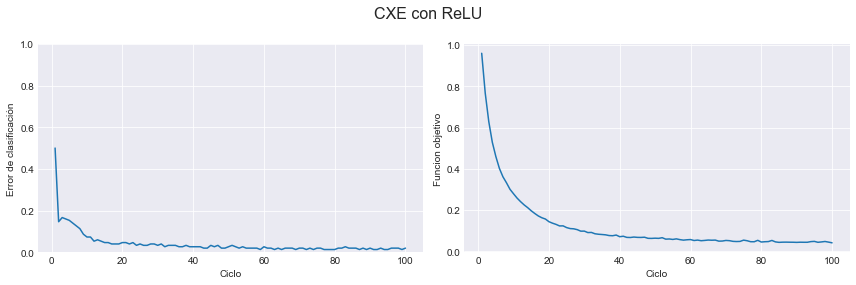

150/150 [==============================] - 0s 313us/step
Final loss: 0.0405582352231
Final training accuracy: 0.979999997616
Time elapsed in training: 1.1749719360359219 seconds.
[[50  0  0]
 [ 0 48  2]
 [ 0  1 49]]


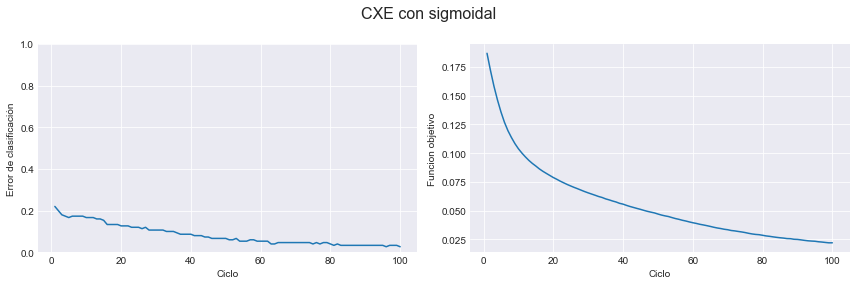

150/150 [==============================] - 0s 313us/step
Final loss: 0.0216027818744
Final training accuracy: 0.973333330949
Time elapsed in training: 0.7677703239206519 seconds.
[[50  0  0]
 [ 0 47  3]
 [ 0  1 49]]


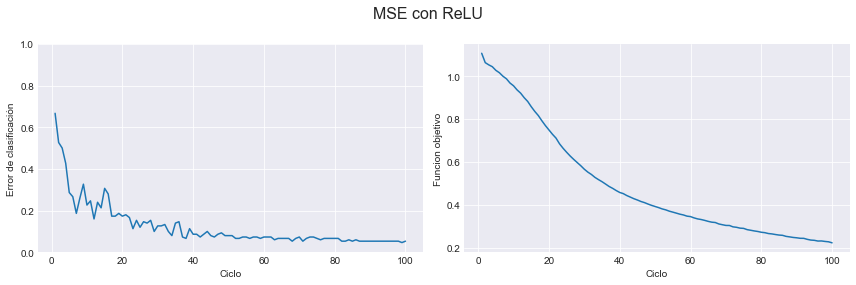

150/150 [==============================] - 0s 313us/step
Final loss: 0.222061856985
Final training accuracy: 0.953333333333
Time elapsed in training: 0.8968986919696746 seconds.
[[50  0  0]
 [ 0 44  6]
 [ 0  1 49]]


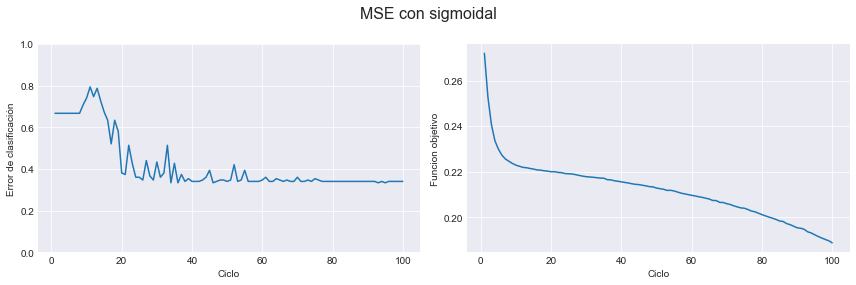

150/150 [==============================] - 0s 417us/step
Final loss: 0.188140443365
Final training accuracy: 0.66
Time elapsed in training: 0.8024006795937972 seconds.
[[50  0  0]
 [22  0 28]
 [ 1  0 49]]


In [10]:
import numpy

for model, title in zip(models, titles):
    start = timer()
    history = model.fit(X_train, y_onehot, epochs = 100, verbose = 0)
    end = timer()
    
    classificationError = [1 - x for x in history.history["acc"]]
    objectiveFunction = history.history["loss"]
    networkPlot(classificationError, objectiveFunction, title)
    
    score = model.evaluate(X_train, y_onehot)
    print("Final loss:", score[0])
    print("Final training accuracy:", score[1])
    print("Time elapsed in training:", end - start, "seconds.")
    
    prediction = model.predict(X_train)
    prediction = convertNetOutput(prediction)
    print(confusion_matrix(y_train, prediction))